In [1]:
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 356 kB 8.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491670 sha256=b776b4ac8d8e5e9d17d8d8da373339b9421e0af8d102157787c4116131f77de3
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import shap
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

Cleaned_df = pd.read_csv('/content/drive/MyDrive/Cleaned_df.csv')

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [4]:
def One_Hot_Encoding(df):

  # One-hot encode the data using pandas get_dummies
  features = pd.get_dummies(df)
  return features

In [5]:
def Mean_Filling(df):

  # Replace infinite updated data with nan
  df.replace([np.inf, -np.inf], np.nan, inplace=True)

  #Mean Filling
  df = df.fillna(df.mean())

  return df

In [6]:
def QQPlots(df):

  #Select only valid types
  df1 = df.select_dtypes (include = ["float64", "int64"])

  #Create list of columns
  cols = df1.columns.tolist()

  for i, column in enumerate(cols):

    print(i, column)
    qqplot(df1[column], line='s')
    pyplot.show()

In [7]:
def Multicollinearity_Reduction(df, MultiCoeff):

  # Create correlation matrix
  corr_matrix = df.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

  # Find index of feature columns with correlation greater than MultiCoeff
  to_drop = [column for column in upper.columns if any(upper[column] > MultiCoeff)]

  # Drop features 
  df = df.drop(df[to_drop], axis=1)

  return df

In [8]:
def Ridge_Method(features, labels):

  # define model
  model = Ridge()
  # define model evaluation method
  cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
  # define grid
  grid = dict()
  grid['alpha'] = np.arange(0, 1000, 10)
  # define search
  search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  # perform the search
  results = search.fit(features, labels)
  # summarize
  print('Mean Absolute Error: %.3f' % results.best_score_)
  print('Config: %s' % results.best_params_)

In [9]:
def Random_Forests(y, X):

  # Saving feature names for later use
  feature_list = list(X.columns)
  # Convert to numpy array
  X = np.array(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

  # define the parameter space that will be searched over
  param_distributions = {'n_estimators': randint(1, 1000),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': randint(1, 5),
                         'min_samples_split': randint(2, 10),
                         'max_depth': randint(1, 100)}

  # now create a searchCV object and fit it to the data
  search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=0),
                              n_iter=10,
                              param_distributions=param_distributions,
                              random_state=0)
  
  search.fit(X_train, y_train)

  RandomizedSearchCV(estimator=RandomForestRegressor(random_state=0), n_iter=5,
                   param_distributions={'n_estimators': ...,
                                        'max_features': ...,
                                        'min_samples_leaf': ...,
                                        'min_samples_split': ...,
                                        'max_depth':...},
                   random_state=0)
  
  Best_scores = search.best_params_
  print('Hyperparameter Tuning:', Best_scores)

In [10]:
def Random_Forests_with_CV(y, X, param_grid): 

  time1 = time.time()
  
  # Saving feature names for later use
  feature_list = list(X.columns)
  # Convert to numpy array
  X = np.array(X)

  # Instantiate model
  rf = RandomForestRegressor(random_state=42)

  # Random Forest Regressor with Grid Search
  CV = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)

  # Train the model on training data
  CV.fit(X, y);
  
  #Calculate R2 score
  r2_score = CV.score(X, y)
  print('r2_score:', round(r2_score, 2))

  # Use the forest's predict method on the test data
  predictions = CV.predict(X)
  # Calculate the absolute errors
  errors = abs(predictions - y)
  # Print out the mean absolute error (mae)
  print('Mean Absolute Error:', round(np.mean(errors), 2))

  # Calculate mean absolute percentage error (MAPE)
  mape = 100 * (errors / y)

  # Calculate and display accuracy
  accuracy = 100 - np.mean(mape)
  print('Accuracy:', round(accuracy, 2), '%.')

  rf.fit(X, y);

  # Get numerical feature importances
  importances = list(rf.feature_importances_)

  # List of tuples with variable and importance

  feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
  # Sort the feature importances by most important first
  feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

  #Ten most important features
  ten_most_important = feature_importances[0:10]

  # Print out the feature and importances 
  [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in ten_most_important];

  time2 = np.round(time.time() - time1,0)
  print("time taken: ", time2)
  
  explainer = shap.Explainer(rf)
  shap_values = explainer(X)
  
  shap.summary_plot(shap_values, X, feature_list)

In [11]:
def GBoost(y, X):

  # Saving feature names for later use
  feature_list = list(X.columns)
  # Convert to numpy array
  X = np.array(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

  # define the parameter space that will be searched over
  param_distributions = {'n_estimators': randint(1, 1000),
                         'min_samples_leaf': randint(1, 5),
                         'min_samples_split': randint(2, 10),
                         'max_depth': randint(1, 100)}

  # now create a searchCV object and fit it to the data
  search = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=0),
                              n_iter=5,
                              param_distributions=param_distributions,
                              random_state=0)
  
  search.fit(X_train, y_train)

  RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=0), n_iter=5,
                   param_distributions={'n_estimators': ...,
                                        'min_samples_leaf': ...,
                                        'min_samples_split': ...,
                                        'max_depth':...},
                   random_state=0)
  
  Best_scores = search.best_params_
  print('Hyperparameter Tuning:', Best_scores)

In [12]:
def GBoost_with_CV(y, X, param_grid):
  
  time1 = time.time()

  # Saving feature names for later use
  feature_list = list(X.columns)
  # Convert to numpy array
  X = np.array(X)

  # Instantiate model
  gb = GradientBoostingRegressor(random_state = 42)

  # Gradient Boosting Regressor with Grid Search
  CV = GridSearchCV(estimator = gb, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)

  # Train the model on training data
  CV.fit(X, y);

  #Calculate R2 score
  r2_score = CV.score(X, y)
  print('r2_score:', round(r2_score, 2))

  # Use GBoost's predict method on the test data
  predictions = CV.predict(X)
  # Calculate the absolute errors
  errors = abs(predictions - y)
  # Print out the mean absolute error (mae)
  print('Mean Absolute Error:', round(np.mean(errors), 2))

  # Calculate mean absolute percentage error (MAPE)
  mape = 100 * (errors / y)

  # Calculate and display accuracy
  accuracy = 100 - np.mean(mape)
  print('Accuracy:', round(accuracy, 2), '%.')
  
  gb.fit(X, y);

  # Get numerical feature importances
  importances = list(gb.feature_importances_)

  # List of tuples with variable and importance
  feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
  
  # Sort the feature importances by most important first
  feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

  #Ten most important features
  ten_most_important = feature_importances[0:10]

  # Print out the feature and importances 
  [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in ten_most_important];

  time2 = np.round(time.time() - time1,0)
  print("time taken: ", time2)

  explainer = shap.Explainer(gb)
  shap_values = explainer(X)
  
  shap.summary_plot(shap_values, X, feature_list)

In [13]:
Cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       2253 non-null   int64  
 1   OSEBuildingID                    2253 non-null   int64  
 2   NumberofBuildings                2253 non-null   float64
 3   NumberofFloors                   2253 non-null   int64  
 4   PropertyGFATotal                 2253 non-null   int64  
 5   PropertyGFAParking               2253 non-null   float64
 6   PropertyGFABuilding(s)           2253 non-null   float64
 7   LargestPropertyUseTypeGFA        2253 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  2253 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   2253 non-null   float64
 10  ENERGYSTARScore                  2253 non-null   float64
 11  SiteEUI(kBtu/sf)                 2253 non-null   float64
 12  SiteEUIWN(kBtu/sf)  

In [14]:
Cleaned_df = Cleaned_df.drop(columns=['Unnamed: 0', 'OSEBuildingID'])

In [15]:
# Creating dataframe of log values
Cleaned_df['Log10SiteEnergyUse'] = np.log10(Cleaned_df['SiteEnergyUse(kBtu)'])
Cleaned_df['Log2SiteEnergyUse'] = np.log2(Cleaned_df['SiteEnergyUse(kBtu)'])
Cleaned_df['LogSiteEnergyUse'] = np.log(Cleaned_df['SiteEnergyUse(kBtu)'])
Cleaned_df['Log2SiteEnergyUse+1'] = (np.log2(1+(Cleaned_df['SiteEnergyUse(kBtu)'])))

Cleaned_df['Log10TotalGHGEmissions'] = np.log10(Cleaned_df['TotalGHGEmissions'])
Cleaned_df['Log2TotalGHGEmissions'] = np.log2(Cleaned_df['TotalGHGEmissions'])
Cleaned_df['LogTotalGHGEmissions'] = np.log(Cleaned_df['TotalGHGEmissions'])
Cleaned_df['Log2TotalGHGEmissions+1'] = (np.log2(1+(Cleaned_df['TotalGHGEmissions'])))

Cleaned_df['Log10ENERGYSTARScore'] = np.log10(Cleaned_df['ENERGYSTARScore'])
Cleaned_df['Log2ENERGYSTARScore'] = np.log2(Cleaned_df['ENERGYSTARScore'])
Cleaned_df['LogENERGYSTARScore'] = np.log(Cleaned_df['ENERGYSTARScore'])
Cleaned_df['Log2ENERGYSTARScore+1'] = (np.log2(1+(Cleaned_df['ENERGYSTARScore'])))

Log_Data = Cleaned_df[['SiteEnergyUse(kBtu)', 'Log10SiteEnergyUse', 'Log2SiteEnergyUse', 'LogSiteEnergyUse', 'Log2SiteEnergyUse+1', 
                       'TotalGHGEmissions', 'Log10TotalGHGEmissions', 'Log2TotalGHGEmissions', 'LogTotalGHGEmissions', 
                       'Log2TotalGHGEmissions+1', 'ENERGYSTARScore', 'Log10ENERGYSTARScore', 'Log2ENERGYSTARScore', 'LogENERGYSTARScore', 'Log2ENERGYSTARScore+1']]

divide by zero encountered in log10
divide by zero encountered in log2
divide by zero encountered in log


In [16]:
Log_Data.head()

,SiteEnergyUse(kBtu),Log10SiteEnergyUse,Log2SiteEnergyUse,LogSiteEnergyUse,Log2SiteEnergyUse+1,TotalGHGEmissions,Log10TotalGHGEmissions,Log2TotalGHGEmissions,LogTotalGHGEmissions,Log2TotalGHGEmissions+1,ENERGYSTARScore,Log10ENERGYSTARScore,Log2ENERGYSTARScore,LogENERGYSTARScore,Log2ENERGYSTARScore+1
0,1454222.0,6.162631,20.471816,14.189982,20.471817,35.17,1.546172,5.136273,3.560193,5.176722,96.0,1.982271,6.584963,4.564348,6.599913
1,3880806.0,6.588922,21.887925,15.171553,21.887925,102.08,2.008941,6.673556,4.625757,6.687621,85.0,1.929419,6.409391,4.442651,6.426265
2,1388717.0,6.142614,20.405321,14.143891,20.405322,9.68,0.985875,3.275007,2.270062,3.416840,0.0,-inf,-inf,-inf,0.000000
3,1472548.0,6.168069,20.489883,14.202505,20.489884,10.27,1.011570,3.360364,2.329227,3.494416,94.0,1.973128,6.554589,4.543295,6.569856
4,306721.0,5.486744,18.226567,12.633694,18.226572,3.71,0.569374,1.891419,1.311032,2.235727,77.0,1.886491,6.266787,4.343805,6.285402


In [17]:
#To change infinite values to the mean
Log_Data = Mean_Filling(Log_Data)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0 SiteEnergyUse(kBtu)


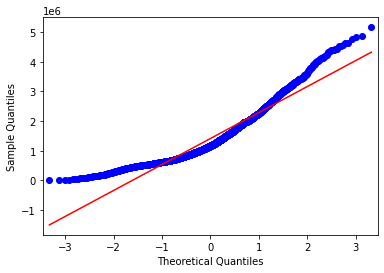

1 Log10SiteEnergyUse


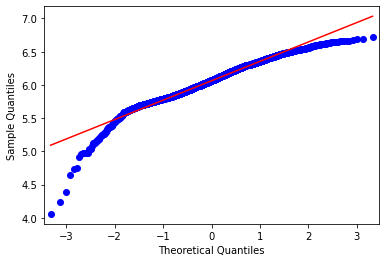

2 Log2SiteEnergyUse


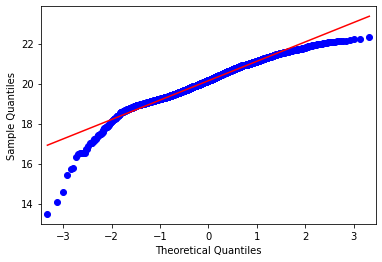

3 LogSiteEnergyUse


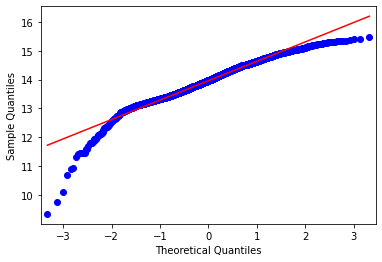

4 Log2SiteEnergyUse+1


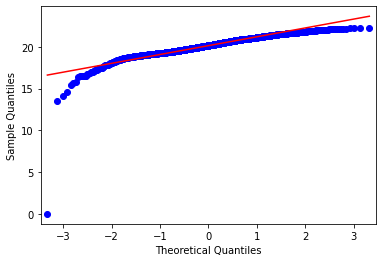

5 TotalGHGEmissions


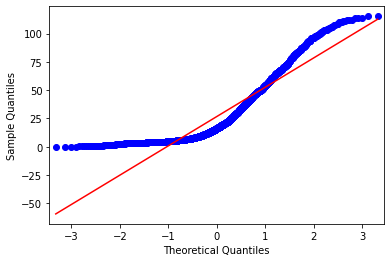

6 Log10TotalGHGEmissions


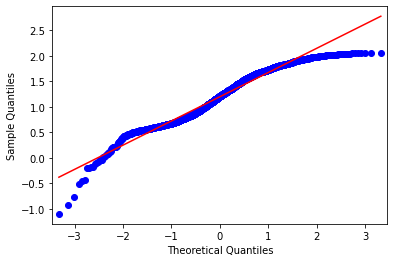

7 Log2TotalGHGEmissions


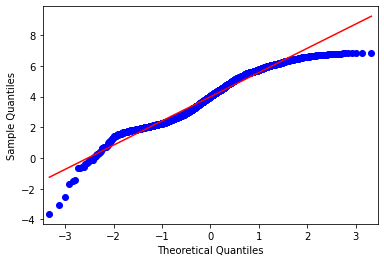

8 LogTotalGHGEmissions


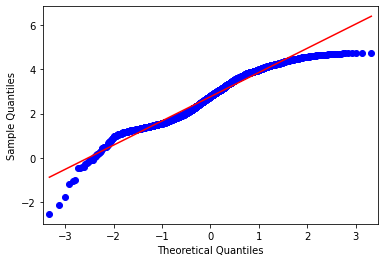

9 Log2TotalGHGEmissions+1


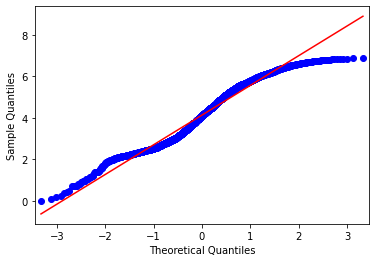

10 ENERGYSTARScore


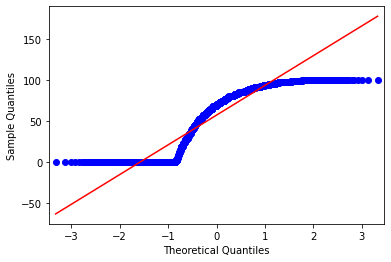

11 Log10ENERGYSTARScore


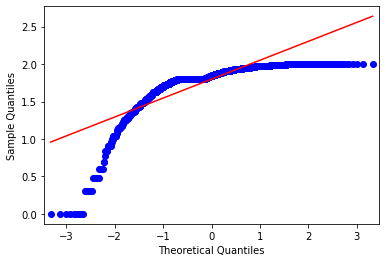

12 Log2ENERGYSTARScore


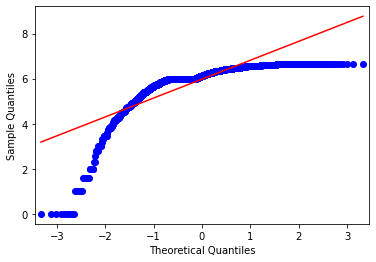

13 LogENERGYSTARScore


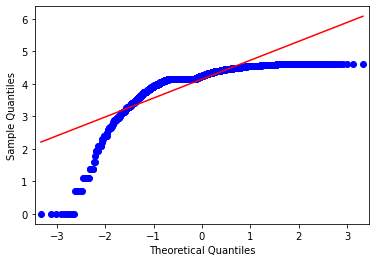

14 Log2ENERGYSTARScore+1


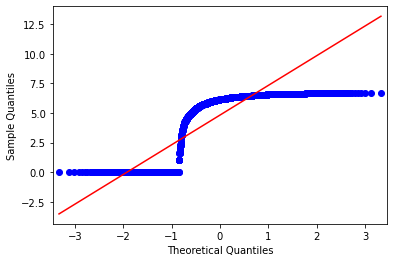

In [18]:
QQPlots(Log_Data)

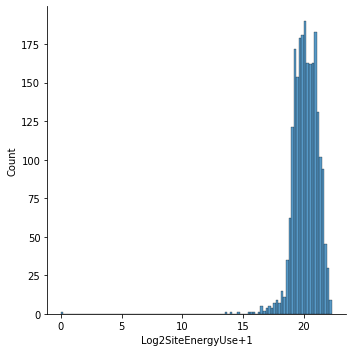

In [19]:
sns.displot(Cleaned_df['Log2SiteEnergyUse+1'])

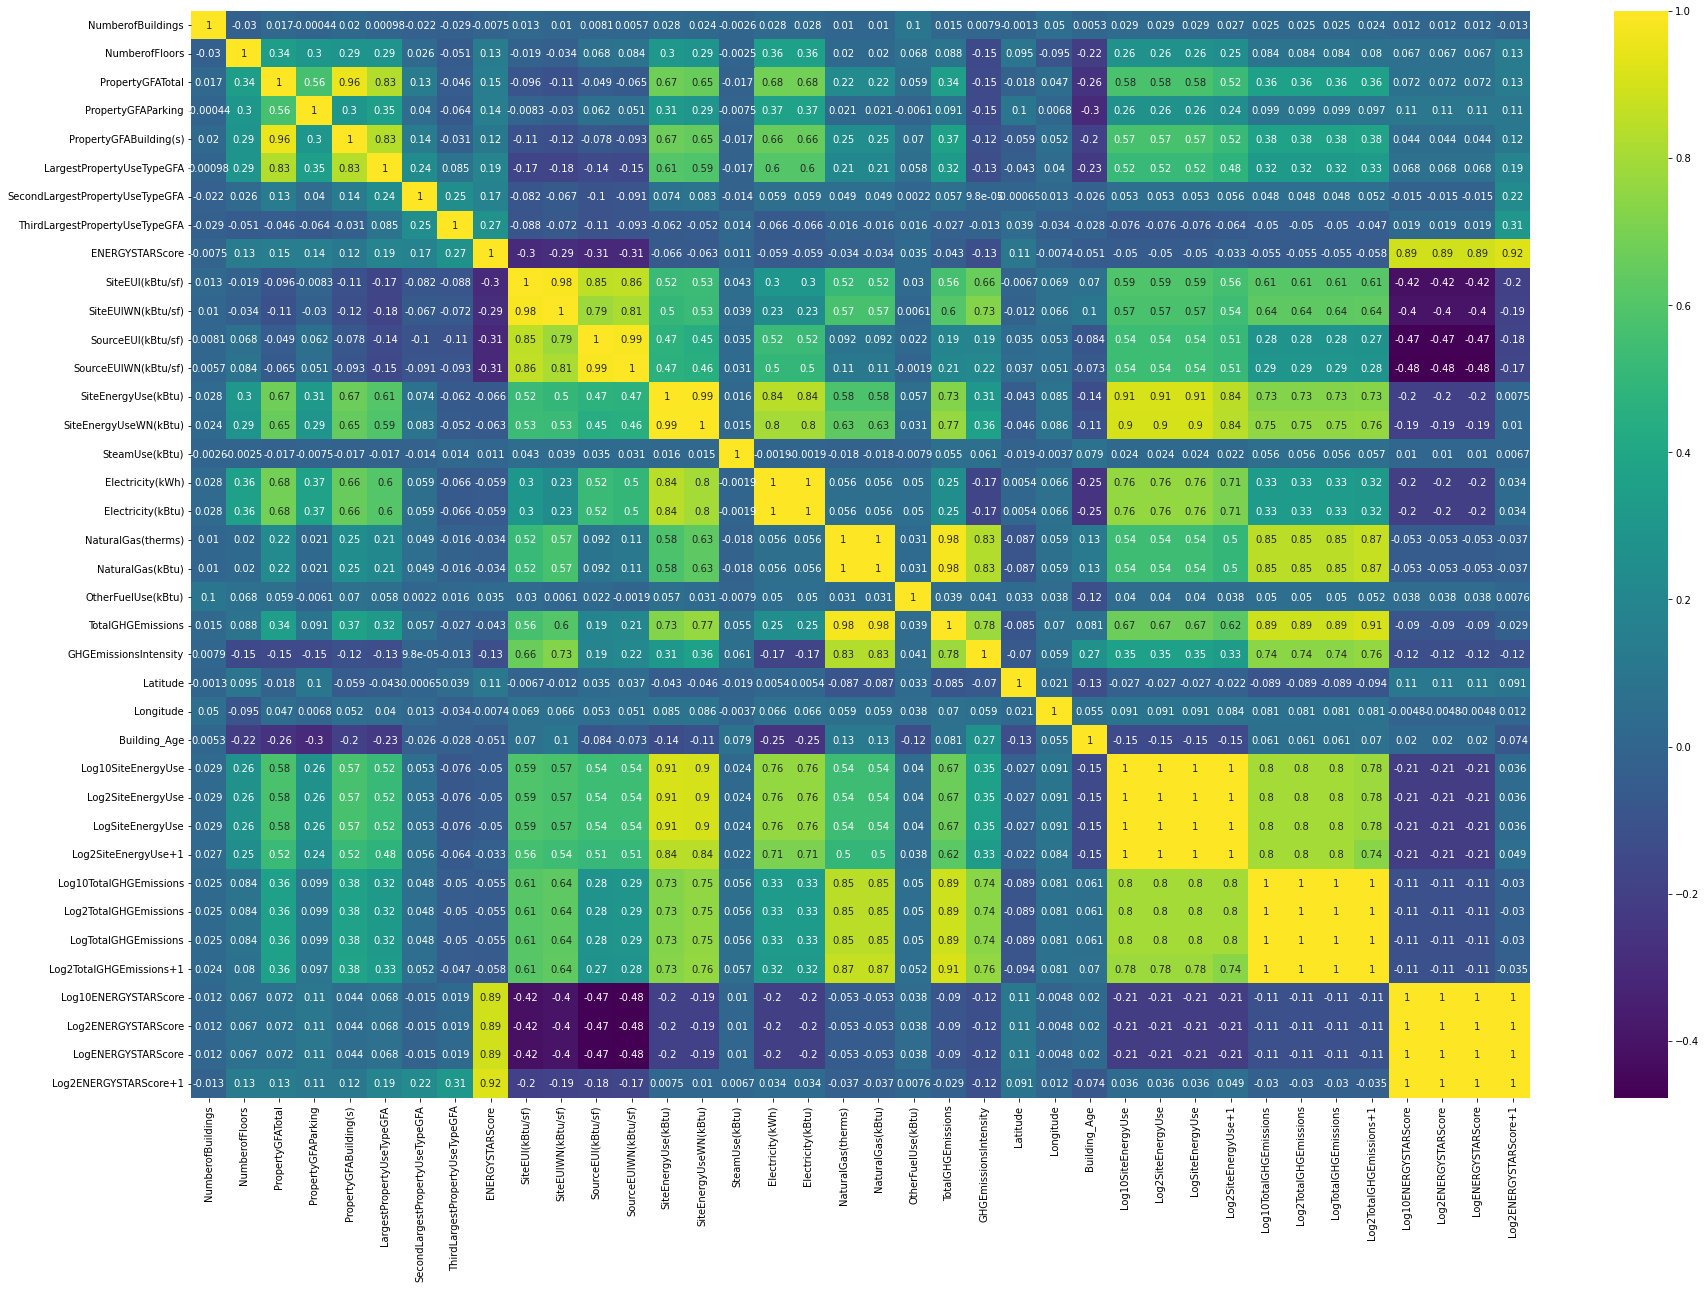

In [20]:
plt.figure(figsize=(30,20))
sns.heatmap(Cleaned_df.corr(),annot=True,cmap='viridis')

In [21]:
# Dropping unrequired log related columns to reduce multicollinearity
Cleaned_df = Cleaned_df.drop(columns=['Log10SiteEnergyUse', 'Log2SiteEnergyUse', 'LogSiteEnergyUse', 'SiteEnergyUse(kBtu)', 'Log10TotalGHGEmissions', 'Log2TotalGHGEmissions', 'LogTotalGHGEmissions', 'Log2TotalGHGEmissions+1'])

In [22]:
#Remove the features with high levels of correlation to reduce multicollinearity
Multi_Coeff = .6

Reduced_df = Multicollinearity_Reduction(Cleaned_df, Multi_Coeff)

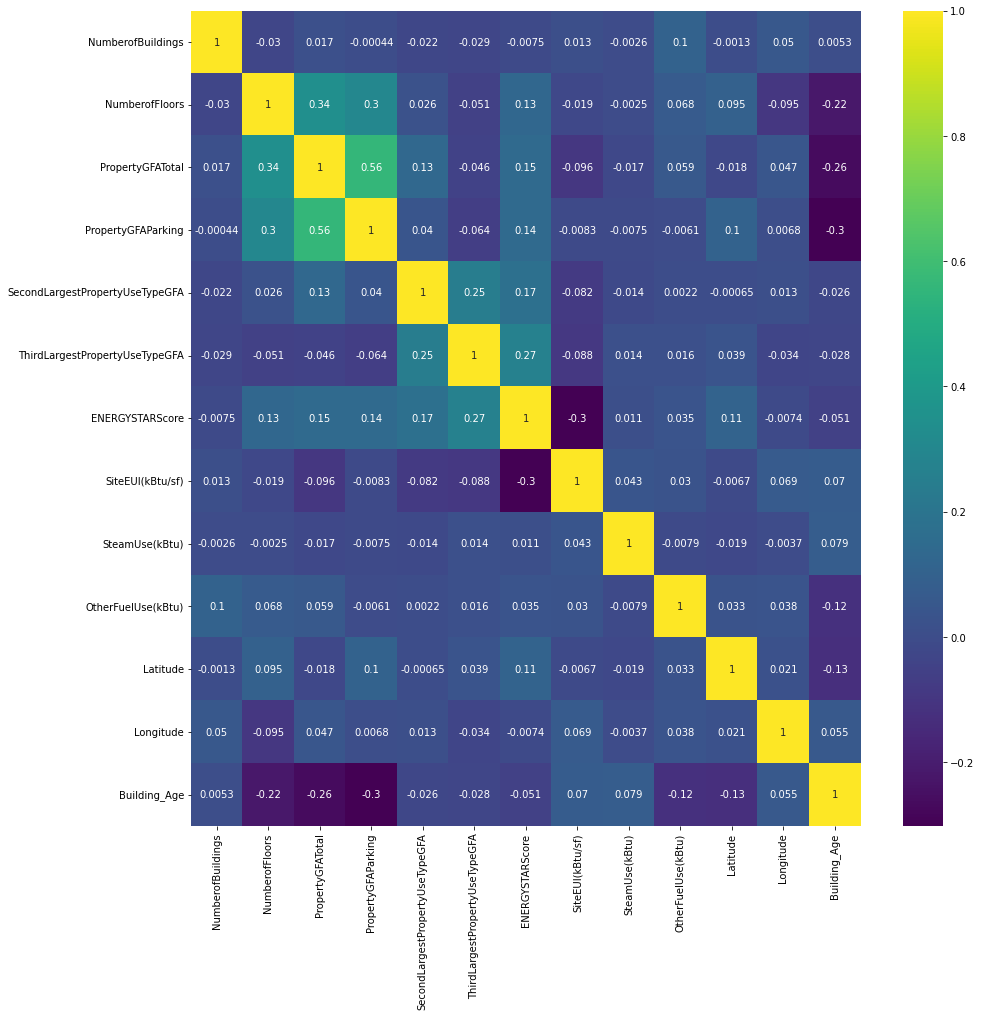

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(Reduced_df.corr(),annot=True,cmap='viridis')

In [24]:
Reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   NumberofBuildings                2253 non-null   float64
 1   NumberofFloors                   2253 non-null   int64  
 2   PropertyGFATotal                 2253 non-null   int64  
 3   PropertyGFAParking               2253 non-null   float64
 4   SecondLargestPropertyUseTypeGFA  2253 non-null   float64
 5   ThirdLargestPropertyUseTypeGFA   2253 non-null   float64
 6   ENERGYSTARScore                  2253 non-null   float64
 7   SiteEUI(kBtu/sf)                 2253 non-null   float64
 8   SteamUse(kBtu)                   2253 non-null   float64
 9   OtherFuelUse(kBtu)               2253 non-null   float64
 10  Latitude                         2253 non-null   float64
 11  Longitude                        2253 non-null   float64
 12  Building_Age        

In [25]:
Machine_Leaning_Data = One_Hot_Encoding(Reduced_df)

In [26]:
Machine_Leaning_Data.shape

(2253, 383)

In [27]:
# Labels are the values we want to predict
labels = np.array(Cleaned_df['Log2SiteEnergyUse+1'])

# The features is the rest of the data
features= Machine_Leaning_Data

In [28]:
Ridge_Method(features, labels)

Mean Absolute Error: -0.303
Config: {'alpha': 50}


In [29]:
Random_Forests(labels, features)

Hyperparameter Tuning: {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 552}


Fitting 3 folds for each of 1 candidates, totalling 3 fits
r2_score: 0.94
Mean Absolute Error: 0.08


divide by zero encountered in true_divide


Accuracy: -inf %.
Variable: SiteEUI(kBtu/sf)     Importance: 0.55
Variable: PropertyGFATotal     Importance: 0.37
Variable: ListOfAllPropertyUseTypes_Non-Refrigerated Warehouse, Other, Retail Store Importance: 0.03
Variable: PropertyGFAParking   Importance: 0.01
Variable: NumberofBuildings    Importance: 0.0
Variable: NumberofFloors       Importance: 0.0
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.0
Variable: ThirdLargestPropertyUseTypeGFA Importance: 0.0
Variable: ENERGYSTARScore      Importance: 0.0
Variable: SteamUse(kBtu)       Importance: 0.0
time taken:  35.0


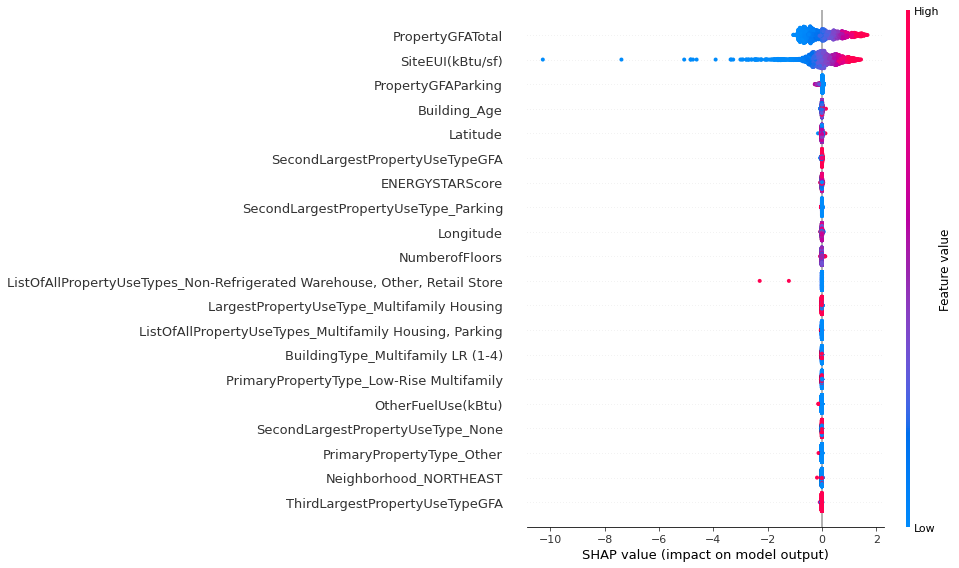

In [30]:
param_grid = {
    'max_depth': [13],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [8],
    'n_estimators': [552]
}

Random_Forests_with_CV(labels, features, param_grid)

In [31]:
GBoost(labels, features)

Hyperparameter Tuning: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 755}


Fitting 3 folds for each of 1 candidates, totalling 3 fits
r2_score: 1.0
Mean Absolute Error: 0.0
Accuracy: -inf %.


divide by zero encountered in true_divide


Variable: SiteEUI(kBtu/sf)     Importance: 0.56
Variable: PropertyGFATotal     Importance: 0.35
Variable: ListOfAllPropertyUseTypes_Non-Refrigerated Warehouse, Other, Retail Store Importance: 0.03
Variable: PropertyGFAParking   Importance: 0.01
Variable: PrimaryPropertyType_Retail Store Importance: 0.01
Variable: SecondLargestPropertyUseType_Non-Refrigerated Warehouse Importance: 0.01
Variable: ThirdLargestPropertyUseType_None Importance: 0.01
Variable: NumberofBuildings    Importance: 0.0
Variable: NumberofFloors       Importance: 0.0
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.0
time taken:  82.0


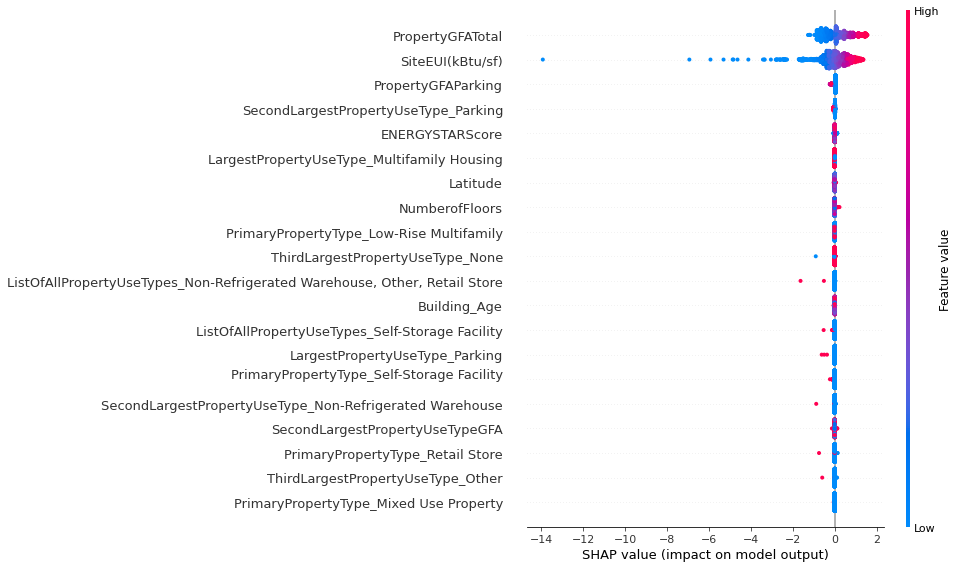

In [32]:
param_grid = {
    'max_depth': [10],
    'min_samples_leaf': [4],
    'min_samples_split': [7],
    'n_estimators': [755]
}

GBoost_with_CV(labels, features, param_grid)

In [33]:
# Labels are the values we want to predict
labels = np.array(Log_Data['Log2TotalGHGEmissions+1'])

# The features is the rest of the data
features= Machine_Leaning_Data

In [34]:
Ridge_Method(features, labels)

Mean Absolute Error: -0.703
Config: {'alpha': 10}


In [35]:
Random_Forests(labels, features)

Hyperparameter Tuning: {'max_depth': 88, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 678}


Fitting 3 folds for each of 1 candidates, totalling 3 fits
r2_score: 0.96
Mean Absolute Error: 0.22
Accuracy: -inf %.


divide by zero encountered in true_divide


Variable: SiteEUI(kBtu/sf)     Importance: 0.48
Variable: PropertyGFATotal     Importance: 0.22
Variable: Building_Age         Importance: 0.06
Variable: ENERGYSTARScore      Importance: 0.05
Variable: Latitude             Importance: 0.03
Variable: Longitude            Importance: 0.02
Variable: NumberofFloors       Importance: 0.01
Variable: PropertyGFAParking   Importance: 0.01
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.01
Variable: BuildingType_NonResidential Importance: 0.01
time taken:  55.0


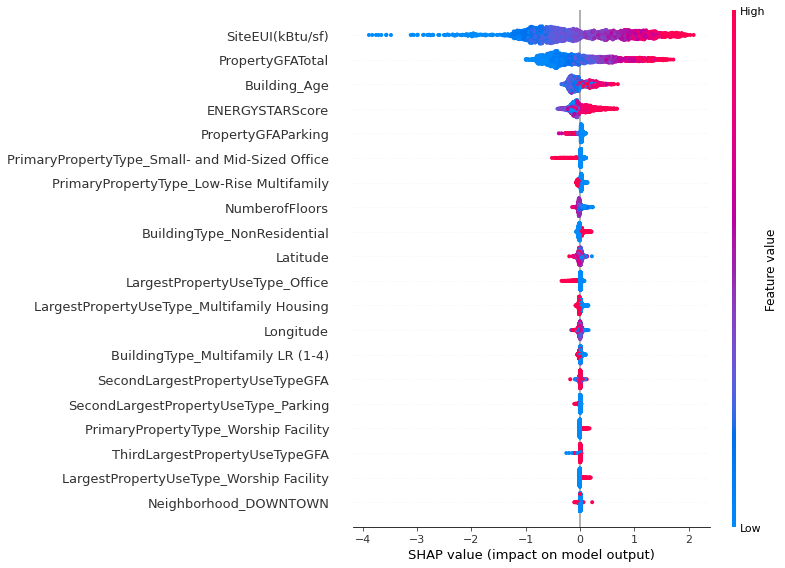

In [36]:
param_grid = {
    'max_depth': [88],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [3],
    'n_estimators': [678]
}

Random_Forests_with_CV(labels, features, param_grid)

In [37]:
GBoost(labels, features)

Hyperparameter Tuning: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 755}


Fitting 3 folds for each of 1 candidates, totalling 3 fits
r2_score: 1.0
Mean Absolute Error: 0.0
Accuracy: -inf %.


divide by zero encountered in true_divide


Variable: SiteEUI(kBtu/sf)     Importance: 0.58
Variable: PropertyGFATotal     Importance: 0.23
Variable: ENERGYSTARScore      Importance: 0.04
Variable: Building_Age         Importance: 0.04
Variable: PrimaryPropertyType_Low-Rise Multifamily Importance: 0.02
Variable: NumberofFloors       Importance: 0.01
Variable: PropertyGFAParking   Importance: 0.01
Variable: PrimaryPropertyType_Small- and Mid-Sized Office Importance: 0.01
Variable: LargestPropertyUseType_Multifamily Housing Importance: 0.01
Variable: LargestPropertyUseType_Office Importance: 0.01
time taken:  75.0


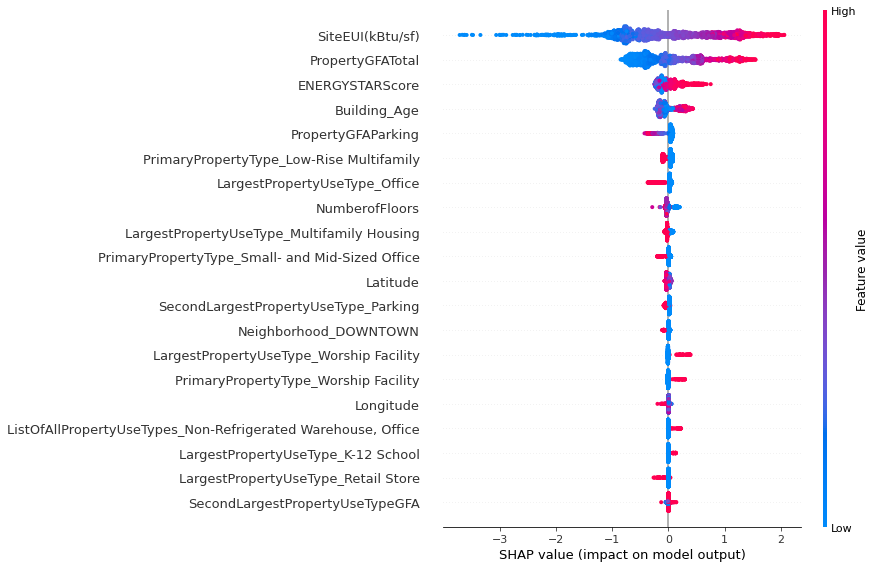

In [38]:
param_grid = {
    'max_depth': [10],
    'min_samples_leaf': [4],
    'min_samples_split': [7],
    'n_estimators': [755]
}

GBoost_with_CV(labels, features, param_grid)

In [39]:
# Labels are the values we want to predict
labels = np.array(Log_Data['Log2ENERGYSTARScore+1'])

# The features is the rest of the data
features= Machine_Leaning_Data.drop('ENERGYSTARScore', axis = 1)

In [40]:
Ridge_Method(features, labels)

Mean Absolute Error: -1.267
Config: {'alpha': 10}


In [41]:
Random_Forests(labels, features)

Hyperparameter Tuning: {'max_depth': 88, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 678}


Fitting 3 folds for each of 1 candidates, totalling 3 fits
r2_score: 0.93
Mean Absolute Error: 0.4
Accuracy: nan %.


divide by zero encountered in true_divide
invalid value encountered in true_divide


Variable: PrimaryPropertyType_Other Importance: 0.16
Variable: ThirdLargestPropertyUseTypeGFA Importance: 0.11
Variable: SiteEUI(kBtu/sf)     Importance: 0.09
Variable: PropertyGFATotal     Importance: 0.07
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.06
Variable: Latitude             Importance: 0.05
Variable: Longitude            Importance: 0.05
Variable: Building_Age         Importance: 0.05
Variable: SecondLargestPropertyUseType_Office Importance: 0.03
Variable: NumberofFloors       Importance: 0.02
time taken:  73.0


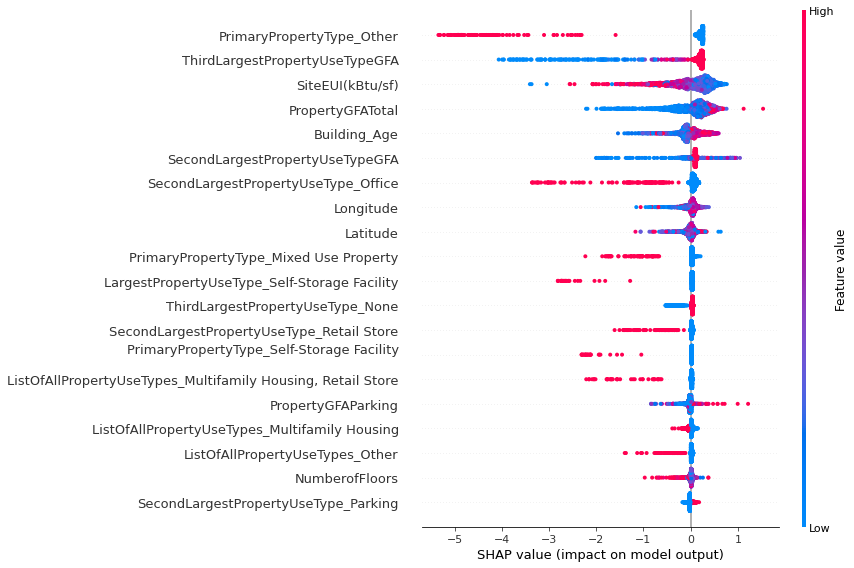

In [42]:
param_grid = {
    'max_depth': [88],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [3],
    'n_estimators': [678]
}

Random_Forests_with_CV(labels, features, param_grid)

In [43]:
GBoost(labels, features)

Hyperparameter Tuning: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 755}


Fitting 3 folds for each of 1 candidates, totalling 3 fits
r2_score: 1.0
Mean Absolute Error: 0.0
Accuracy: -inf %.


divide by zero encountered in true_divide


Variable: PrimaryPropertyType_Other Importance: 0.25
Variable: ThirdLargestPropertyUseTypeGFA Importance: 0.13
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.08
Variable: SiteEUI(kBtu/sf)     Importance: 0.06
Variable: PropertyGFATotal     Importance: 0.05
Variable: PrimaryPropertyType_Mixed Use Property Importance: 0.04
Variable: PrimaryPropertyType_Self-Storage Facility
 Importance: 0.04
Variable: SecondLargestPropertyUseType_Parking Importance: 0.04
Variable: ThirdLargestPropertyUseType_None Importance: 0.04
Variable: LargestPropertyUseType_Self-Storage Facility Importance: 0.03
time taken:  73.0


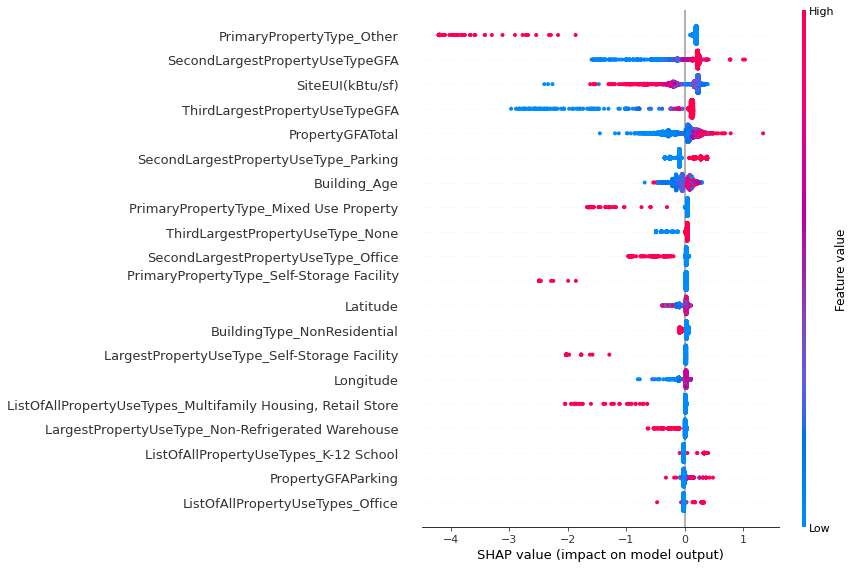

In [44]:
param_grid = {
    'max_depth': [10],
    'min_samples_leaf': [4],
    'min_samples_split': [7],
    'n_estimators': [755]
}

GBoost_with_CV(labels, features, param_grid)

Conclusion:

Three machine learning models were selected for this project Random Forests and GBoost had very similar performance, so it is practically impossible to choose between them.

Of the three, the ridge method was the worst predictor. For this model, hyperparameters between 0 and 1000 were tested.

Of the three datasets chosen for analysis, all three models performed well on SiteEnergyUse and TotalGHGEmissions data (both were cleaned and converted in the log).

All three models performed very poorly for the prediction of LogENERGYSTARScore, this is not surprising because according to the corresponding QQ plots, LogENERGYSTARScore does not show normal distrubtion characteristics. 